In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
                                                             #YAZI SINIFLANDIRMA ÇALIŞMASI

In [3]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [5]:
df = df.dropna(subset=["description","points"])

In [6]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


<function matplotlib.pyplot.show(close=None, block=None)>

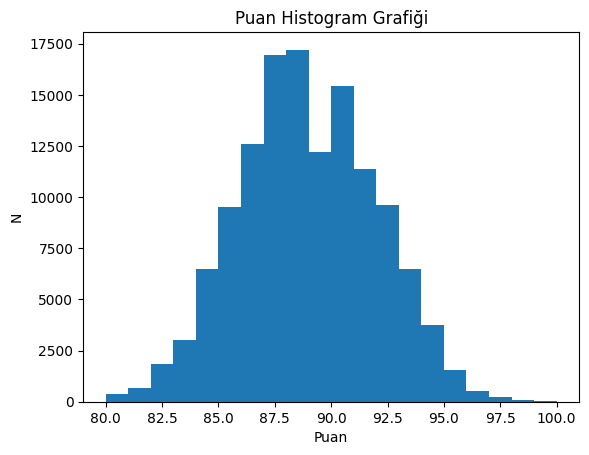

In [7]:
plt.hist(df.points, bins=20)
plt.title("Puan Histogram Grafiği")
plt.xlabel("Puan")
plt.ylabel("N")
plt.show

In [8]:
df["label"] = (df.points >=90).astype(int)         #veriyi kabaca bölüyorum , binary şekilde puanı 90 veüstü olan 1 olacak yeni kolon
df = df[["description" , "points" , "label"]]      #kullanacağım veriler


In [9]:
df.head() , df.tail()

(                                         description  points  label
 0  Aromas include tropical fruit, broom, brimston...      87      0
 1  This is ripe and fruity, a wine that is smooth...      87      0
 2  Tart and snappy, the flavors of lime flesh and...      87      0
 3  Pineapple rind, lemon pith and orange blossom ...      87      0
 4  Much like the regular bottling from 2012, this...      87      0,
                                               description  points  label
 129966  Notes of honeysuckle and cantaloupe sweeten th...      90      1
 129967  Citation is given as much as a decade of bottl...      90      1
 129968  Well-drained gravel soil gives this wine its c...      90      1
 129969  A dry style of Pinot Gris, this is crisp with ...      90      1
 129970  Big, rich and off-dry, this is powered by inte...      90      1)

In [10]:
train , val , test = np.split(df.sample(frac=1) , [int(0.8 * len(df)) , int(0.9 * len(df))])      #Train , val test datasını paylaştırma (bu yazım daha yönet)
                                                                                                  #train %80 (ilk bölme) , val %80-90 arası %10 , test %90-100 arası %10

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))                                 #TENSORFLOW MODÜLÜNDEN ÇEKTİĞİM BİR FONKSİYON TÜM TRAİN,VAL,TEST DF LERİNİ  
  if shuffle:                                                                           #TF.DATA.DATASET OBJESİ YAPIYOR , KARIŞTIRIP HARMANLIYOR
    ds = ds.shuffle(buffer_size=len(dataframe))                                         #KENDİ KODUMA GÖRE DÜZENLEDİM
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)                                         #FONK KULLANIP BÖLDÜĞÜM DF LERİ TF.DATA.DATASET OBJESİNE ÇEVİRDİM
test_data = df_to_dataset(test)

In [13]:
list(train_data)[0]                                                     #TF DATASET OLDUĞUNDAN ÇEVİRİP İNCELENEBİLİR

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"A reedy and odd-smelling wine. No matter how many times you come back to it, there's the scent of latex and a strange perfume to the nose. In the mouth, it's tannic and blocky, with saturated black cherry and a funky, unfamiliar twist. And it finishes with rubber, plastic, cotton candy and coconut notes. Can't say this does much to push Carmen\xc3\xa8re's status.",
        b'Milk chocolate, dark cherry, herb and floral notes are followed by silky smooth pit fruit flavors that linger.',
        b'Honey, peach, citrus and dried herbs comprise the nose of this simple Pinot Grigio. In appearance, the wine is almost transparent with a touch of gold and the mouthfeel is equally light and easy. The screwcap bottle has a cute picture of a green Vespa on the label to reinforce its all-Italy, Dolce Vita appeal.',
        ...,
        b'Finely balanced, crisp and clean, a pure delight. The wine has a delicious swathe of fresh strawberry a

MODEL VE EMBEDDİNG


In [14]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"                  # nnlm-en-dim50 gömülü eng-num çeviri yapan hazır model
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)  #embedding url gönderip , dttype = str gönderip , eğitebilirliği açıyorum

In [15]:
hub_layer(list(train_data)[0][0])                                       #STR kelimeler bilgisayarın işleyeceği numpy array objesi oldu
                                                                        #sadece str geçirmek gerekiyor

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.2924445 , -0.22240701,  0.13830127, ...,  0.27218175,
        -0.21169522, -0.13623825],
       [ 0.3590108 , -0.09464917,  0.14376253, ...,  0.0885267 ,
        -0.26327834, -0.01396794],
       [ 0.36770472, -0.09338002, -0.03038859, ...,  0.08976828,
        -0.20958844,  0.09610091],
       ...,
       [ 0.7267641 , -0.10085777, -0.1800408 , ...,  0.01840592,
        -0.00759446, -0.2483985 ],
       [ 0.1963705 , -0.0210008 , -0.06296231, ..., -0.06936225,
        -0.37901264, -0.05858324],
       [ 0.39224294, -0.11558172,  0.01858793, ..., -0.10786718,
        -0.25929067, -0.14797847]], dtype=float32)>

In [16]:
model = tf.keras.Sequential()                                             #Klasik Sequential modeli
model.add(hub_layer)                                                      #İlk olarak yukarıdaki hub layer ekliyorum 
model.add(tf.keras.layers.Dense(16, activation='relu'))                   #Klasik ilk Dense katmanı
model.add(tf.keras.layers.Dense(16, activation='relu'))                   #Klasik ikinci Dense katmanı
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),                    #Klasik model compile daha önceden çektim
              metrics=['accuracy'])

In [18]:
model.evaluate(train_data)                                                  #train data değerlendirme

102/102 [==============================] - 2s 10ms/step - loss: 0.6654 - accuracy: 0.6198


[0.6654357314109802, 0.619796872138977]

In [19]:
model.evaluate(valid_data)                                                  #valid data değerlendirme

13/13 [==============================] - 0s 13ms/step - loss: 0.6680 - accuracy: 0.6114


[0.6679756045341492, 0.6113718748092651]

In [21]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)      #eğitim

Epoch 1/10
102/102 [==============================] - 86s 842ms/step - loss: 0.2911 - accuracy: 0.8740 - val_loss: 0.3685 - val_accuracy: 0.8334
Epoch 2/10
102/102 [==============================] - 89s 874ms/step - loss: 0.2739 - accuracy: 0.8835 - val_loss: 0.3761 - val_accuracy: 0.8346
Epoch 3/10
102/102 [==============================] - 88s 863ms/step - loss: 0.2598 - accuracy: 0.8912 - val_loss: 0.3810 - val_accuracy: 0.8332
Epoch 4/10
102/102 [==============================] - 89s 869ms/step - loss: 0.2484 - accuracy: 0.8959 - val_loss: 0.3888 - val_accuracy: 0.8301
Epoch 5/10
102/102 [==============================] - 89s 875ms/step - loss: 0.2371 - accuracy: 0.9012 - val_loss: 0.3957 - val_accuracy: 0.8303
Epoch 6/10
102/102 [==============================] - 90s 886ms/step - loss: 0.2265 - accuracy: 0.9074 - val_loss: 0.4069 - val_accuracy: 0.8300
Epoch 7/10
102/102 [==============================] - 90s 882ms/step - loss: 0.2162 - accuracy: 0.9115 - val_loss: 0.4186 - val_ac

                                            VAL_LOSS VE VAL_ACCURACY bakarsak OVERFİTTİNG vardır tarin datayı çok iyi anlıyo fakat genelleme kötüye gidiyor

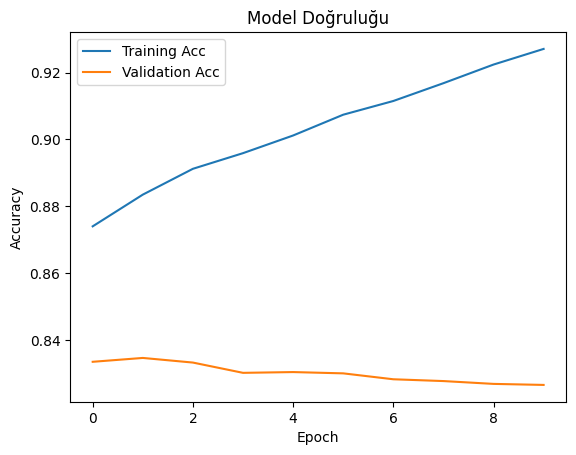

In [23]:

plt.plot(history.history['accuracy'],label="Training Acc")
plt.plot(history.history['val_accuracy'],label="Validation Acc")
plt.title("Model Doğruluğu")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()


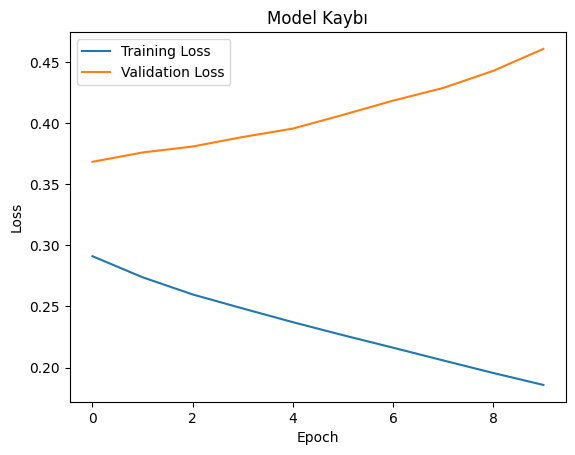

In [24]:
plt.plot(history.history['loss'],label="Training Loss")
plt.plot(history.history['val_loss'],label="Validation Loss")
plt.title("Model Kaybı")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()


Çok Fazla eğitim yaptığımdan model genelleyemiyor yeni modelde ayarlar değişik olucak

In [25]:
model2 = tf.keras.Sequential()
model2.add(hub_layer)
model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.4))                        #Dropout eklemesi overfitting önüne geçmek için yanış data besleyen ara katman gibi
model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [27]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),                    #Klasik model compile yukarıdan çektim
              metrics=['accuracy'])

In [28]:
model2.evaluate(train_data)                                                  #train data değerlendirme

102/102 [==============================] - 9s 86ms/step - loss: 0.6917 - accuracy: 0.4978


[0.6917413473129272, 0.497816801071167]

In [30]:
model2.evaluate(valid_data)                                                  #valid data değerlendirme

13/13 [==============================] - 1s 84ms/step - loss: 0.6920 - accuracy: 0.4914


[0.6919736266136169, 0.491421103477478]

In [31]:
history = model2.fit(train_data, epochs=5, validation_data=valid_data)      #Yeni eğitim epochs düşürdüm ve modele dropout eklemiştim overfitting önüne geçmek için

Epoch 1/5
102/102 [==============================] - 72s 698ms/step - loss: 0.5496 - accuracy: 0.7326 - val_loss: 0.3998 - val_accuracy: 0.8227
Epoch 2/5
102/102 [==============================] - 74s 729ms/step - loss: 0.3555 - accuracy: 0.8537 - val_loss: 0.3861 - val_accuracy: 0.8277
Epoch 3/5
102/102 [==============================] - 72s 705ms/step - loss: 0.3108 - accuracy: 0.8751 - val_loss: 0.3942 - val_accuracy: 0.8283
Epoch 4/5
102/102 [==============================] - 72s 706ms/step - loss: 0.2926 - accuracy: 0.8836 - val_loss: 0.4093 - val_accuracy: 0.8261
Epoch 5/5
102/102 [==============================] - 73s 715ms/step - loss: 0.2761 - accuracy: 0.8908 - val_loss: 0.4266 - val_accuracy: 0.8262


                                        VAL_LOSS ve VAL_ACCURACY değer şaşmaları nispeten azaldı
                                        Bu model öncekinden daha iyi genelleme yapabilen bir model olmuştur

In [32]:
model2.evaluate(test_data)                              #modelin son değerlendirmesi için 

13/13 [==============================] - 1s 80ms/step - loss: 0.4357 - accuracy: 0.8227


[0.4357354938983917, 0.8226650357246399]

                                                Model üzerinde daha fazla hakimiyet sağlayan LSTM diye bir yöntem buldum onu deneyeceğim
LSTM

In [33]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)                  #Encoder oluşturarak başlıyorum
encoder.adapt(train_data.map(lambda text, label: text))                       #Train datada hem text hem data var sadece text kullacağımdan lambda fonk ile çevirdim , Label olmasa da olur

In [34]:
vocab = np.array(encoder.get_vocabulary())                                      # encoderda encodlanan kelimeleri değişkene atama
vocab[:20]                                                                      #ilk 20 kelimeyi gösterme

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [42]:
                                    #Şimdi tekrar model Oluşturma
model = tf.keras.Sequential([
    encoder,                                                #İlk Encoder geçiriyorum , texti vektörleştirecek olan budur
    tf.keras.layers.Embedding(                              #Encoder vektörleşen text için embedding lazım 
        input_dim=len(encoder.get_vocabulary()),            #Tüm vocabulary uzunluğunu girişe verdik
        output_dim=32,                                      #çıkışta LSTM miktarı
        mask_zero=True                                      #değişken uzunluğunu ayarlama için bu yapılmalıymış
                                                            #encoder ile embeding bu ikisi bir cümleyi sayı vektörüne dönüştürüp işlememi sağlayacak
    ),
    tf.keras.layers.LSTM(32),                               #LSTM katmanı 32 geçmiştim
    tf.keras.layers.Dense(32, activation='relu'),           #Dense Katmanı
    tf.keras.layers.Dropout(0.4),                           #Dropout ekliyorum overtrainig olabiliyor bu datada
    tf.keras.layers.Dense(1, activation='sigmoid')          #Çıkış Dense Katmanında activation sigmoid 

])

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),                    #Klasik model compile yukarıdan çektim
              metrics=['accuracy'])

In [44]:
model.evaluate(train_data)
model.evaluate(valid_data)                                  #Model değerlendirmesi

13/13 [==============================] - 2s 120ms/step - loss: 0.6939 - accuracy: 0.4060


[0.6938971877098083, 0.4060167670249939]

            Model değerlendirmesi pek hoş değil ama bi eğitmeli

In [45]:
history2 = model.fit(train_data , epochs=5 , validation_data=valid_data)        #yukarıdaki eğitimin benzeri epochs=5 daha iyi sonuç vermişti

Epoch 1/5
102/102 [==============================] - 38s 326ms/step - loss: 0.5400 - accuracy: 0.7175 - val_loss: 0.3776 - val_accuracy: 0.8278
Epoch 2/5
102/102 [==============================] - 34s 332ms/step - loss: 0.3703 - accuracy: 0.8367 - val_loss: 0.3668 - val_accuracy: 0.8308
Epoch 3/5
102/102 [==============================] - 33s 323ms/step - loss: 0.3503 - accuracy: 0.8455 - val_loss: 0.3518 - val_accuracy: 0.8356
Epoch 4/5
102/102 [==============================] - 30s 296ms/step - loss: 0.3436 - accuracy: 0.8485 - val_loss: 0.3476 - val_accuracy: 0.8411
Epoch 5/5
102/102 [==============================] - 31s 298ms/step - loss: 0.3373 - accuracy: 0.8505 - val_loss: 0.3523 - val_accuracy: 0.8420


                                            Model gidişatı tam ayar oldu

In [46]:
model.evaluate(test_data)

13/13 [==============================] - 1s 112ms/step - loss: 0.3583 - accuracy: 0.8385


[0.3582839071750641, 0.8385136127471924]

                                            Değerlendirmesi de başarılı